In [1]:
import numpy as np
from tqdm import tqdm

# グローバルでシードを設定
np.random.seed(42)

#####################################
# Set parameters
#####################################
fiber_length = 10  # Fiber length (m)
# width = 200e-6  # Fiber core width  (m)
width =1e-5
nref = 1.4611  # Fiber refractive index
na = 0.39  # N.A.

lw0 = 1550.0e-9  # center wavelgnth (m)
c = 3.0e8  # light velocity (m/s)
omega0 = 2.0 * np.pi * c / lw0  # angular frequency (rad/s)
kw = omega0 / c  # wavenumber (1/m)

####### Spatial sampling ###
# num_x_pixel = 200
# num_y_pixel = 200
# dx = width / num_x_pixel
# dy = width / num_y_pixel
# x = np.arange(1, num_x_pixel + 1) * dx
# y = np.arange(1, num_y_pixel + 1) * dy

####### Input signal ######
# time_length = 10  # Time length of input signal
dt_w = 0.04e-9  # Time interval of input signal (s)
dt_samp = 0.02e-9  # Sampling time interval (s)
al = 2.0 * np.pi  # Input signal amplitude
num_repeat = int(dt_w / dt_samp)  # number of repeat


######################################
# Fixed parameters
######################################
def generate_mask_pattern(
    time_length=10, num_x_pixel_true=200, num_y_pixel_true=200
) -> np.ndarray:  # (time_length, num_x_pixel, num_y_pixel)
    ####### Spatial sampling ###
    num_x_pixel = num_x_pixel_true + 1
    num_y_pixel = num_y_pixel_true + 1
    dx = width / num_x_pixel
    dy = width / num_y_pixel
    x = np.arange(1, num_x_pixel + 1) * dx
    y = np.arange(1, num_y_pixel + 1) * dy
    # ----------- Multimode fiber --------------
    V_number = (np.pi * width / lw0) * na  # normalized frequency
    num_sq_modes = int(np.sqrt(0.5 * V_number * V_number))
    num_modes = num_sq_modes * num_sq_modes  # num. of excited modes

    # xy wavenumbers
    kx = np.linspace(1, num_sq_modes, num_sq_modes) * (np.pi / width)
    ky = np.linspace(1, num_sq_modes, num_sq_modes) * (np.pi / width)

    # beta wavenumbers & mode patterns
    _beta = np.zeros(num_modes)
    _psi = np.zeros((num_modes, num_x_pixel, num_y_pixel))
    for i in range(num_sq_modes):
        for j in range(num_sq_modes):
            m = num_sq_modes * i + j
            _beta[m] = np.sqrt(nref * nref * kw * kw - kx[i] * kx[i] - ky[j] * ky[j])
            _psi[m, :, :] = np.matmul(
                np.array(
                    [
                        np.sin(kx[i] * x),
                    ]
                ).T,
                np.array(
                    [
                        np.sin(ky[j] * y),
                    ]
                ),
            )

    # sorting
    beta = np.sort(_beta)
    psi = _psi[np.argsort(_beta), :, :]

    # dispersion, d\beta/d\omega
    disp = ((nref * nref) / (c * c)) * omega0 / beta
    # time delay
    time_delay = disp * fiber_length
    # relative time delay
    relative_time_delay = time_delay - time_delay[0]
    # index
    i_delay = relative_time_delay / dt_samp
    i_delay = i_delay.astype(int)

    # mode amplitudes
    aa = np.random.uniform(-1.0, 1.0, num_modes) + 1j * np.random.uniform(
        -1.0, 1.0, num_modes
    )
    aa = aa * np.exp(1j * beta * fiber_length)

    # Input signal
    _uu = np.random.uniform(-1.0, 1.0, int(time_length / num_repeat))
    uu = al * np.repeat(_uu, num_repeat)

    # time delay
    uu_delay = np.zeros((num_modes, time_length))
    for m in range(num_modes):
        uu_delay[m] = np.roll(uu, i_delay[m])
    # phase modulated input singal
    phase_modulated_input = np.exp(1j * uu_delay)

    # speckle field
    mask_speckles = np.zeros((time_length, num_x_pixel, num_y_pixel)) * 1j
    for n in tqdm(range(time_length)):
        for m in range(num_modes):
            mask_speckles[n, :, :] += aa[m] * psi[m, :, :] * phase_modulated_input[m, n]

    mask_patterns = np.abs(mask_speckles) ** 2
    # oversampling
    # print(mask_patterns.shape)
    mask_patterns_cropped = mask_patterns.astype(float)[
        :, :num_x_pixel_true, :num_y_pixel_true
    ]
    mask_patterns_normalized = mask_patterns_cropped / np.mean(mask_patterns_cropped)

    # save mask_patterns as npz
    np.savez(
        f"mask_patterns_length{fiber_length}_core{width}.npz",
        mask_patterns_normalized,
    )
    print("Saved!")
    return mask_patterns_normalized


In [2]:
mask = generate_mask_pattern(time_length=784, num_x_pixel_true=28, num_y_pixel_true=28)

  0%|          | 0/784 [00:00<?, ?it/s]

100%|██████████| 784/784 [00:00<00:00, 12768.94it/s]

Saved!


In [7]:
mask.shape

(784, 28, 28)

動画を保存しました: mask_patterns_length10_core1e-05.mp4


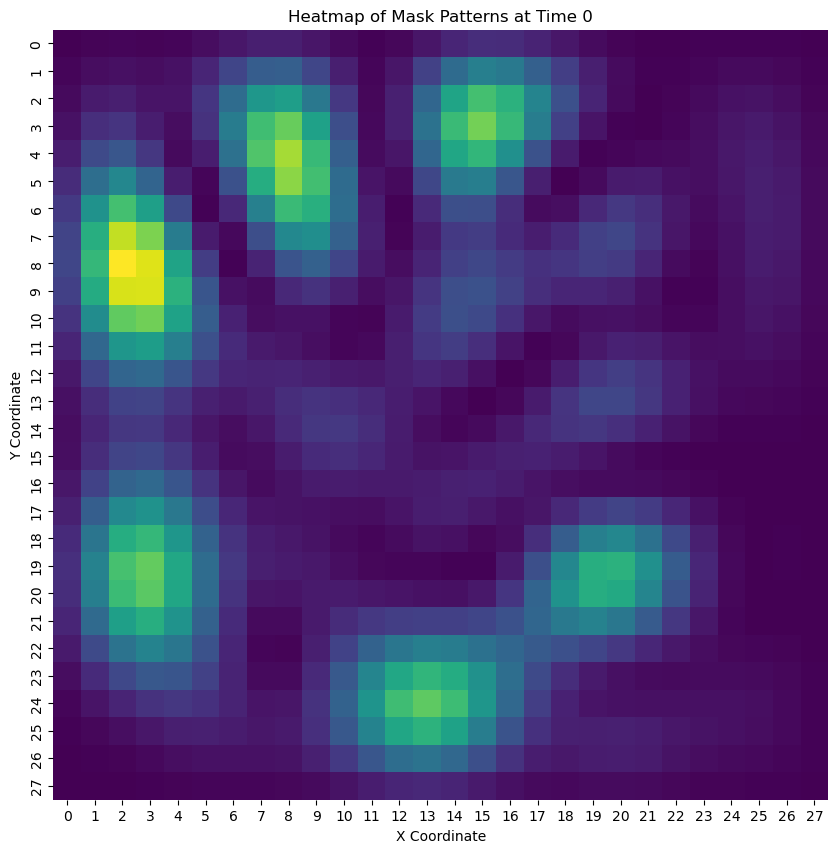

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import matplotlib.animation as animation

# # 保存する動画のファイル名
# video_filename = f"mask_patterns_length{fiber_length}_core{width}.mp4"  # MP4形式で保存
# # video_filename = "mask_patterns.gif"  # GIF形式で保存する場合

# # データの例（実際のデータをmaskに代入すること）
# # mask = np.random.rand(10, 28, 28)  # (時刻, X, Y)

# t_max = mask.shape[0]  # データの最大時刻数

# fig, ax = plt.subplots(figsize=(10, 10))

# def update(frame):
#     """ アニメーションのフレーム更新 """
#     ax.clear()
#     sns.heatmap(mask[frame, :, :], cmap="viridis", cbar=False, ax=ax)
#     ax.set_title(f"Heatmap of Mask Patterns at Time {frame}")
#     ax.set_xlabel("X Coordinate")
#     ax.set_ylabel("Y Coordinate")

# ani = animation.FuncAnimation(fig, update, frames=t_max, interval=200)

# # 動画をMP4形式で保存（FFmpegが必要）
# ani.save(video_filename, writer="ffmpeg", fps=5, dpi=100)

# # GIFで保存する場合（Pillowを使用）
# # ani.save(video_filename, writer="pillow", fps=5)

# print(f"動画を保存しました: {video_filename}")


100%|██████████| 100/100 [00:00<00:00, 431.10it/s]


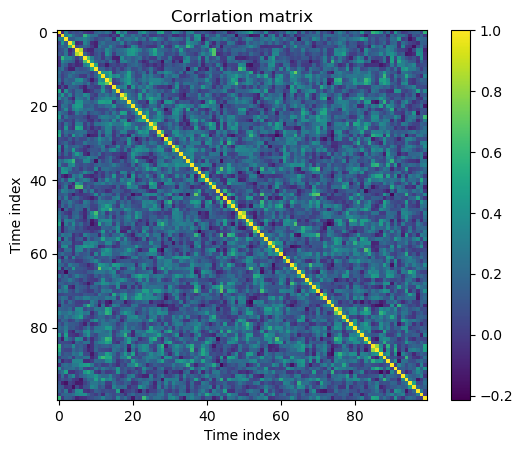

In [5]:
time_length = 100
num_x_pixel=28
num_y_pixel = 28
corr = np.zeros((time_length,time_length))
for n0 in tqdm( range(time_length) ):
    for n1 in range(time_length):
        corr[n0,n1] = np.corrcoef(mask[n0].reshape(num_x_pixel*num_y_pixel),mask[n1].reshape(num_x_pixel*num_y_pixel))[0,1]

fig = plt.figure()
ax  = fig.add_subplot(1,1,1)
ax.set_title("Corrlation matrix")
ax.set_xlabel("Time index")
ax.set_ylabel("Time index")
cc = ax.imshow(corr)
fig.colorbar(cc)
plt.show()